In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%load_ext autoreload
%autoreload 2
from utils import *

import numpy as np
import pandas as pd
from tqdm import tqdm
# from datetime import datetime
# from datetime import timedelta, time
import datetime
import matplotlib.pyplot as plt
import os
import lightgbm as lgbm
import warnings
from utils import *
import seaborn as sns
from sklearn.metrics import accuracy_score, log_loss
from parameters import top_tickers, ibkr_info

sns.set()

warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [222]:
load_tickers(data_prefix="../ssd/finance_data", tickers=np.array(list(ibkr_info.keys()))[:], start_date=datetime.strptime("20190101", "%Y%m%d").date(), end_date=datetime.today().date() + timedelta(days=1), period=2)

100%|██████████| 30/30 [10:56<00:00, 21.88s/it]


In [42]:
ticker2df = load_dfs('../ssd/finance_data', np.array(list(ibkr_info.keys())))

In [3]:
ticker2df = load_dfs('../ssd/finance_data', ['MOEX', 'AFLT'])

In [4]:
len(ticker2df)

2

In [4]:
val_start_date = np.datetime64('2020-05-26') - np.timedelta64(30, 'D')
test_start_date = np.datetime64('2020-05-26') - np.timedelta64(15, 'D')

all_train_datetimes = df_between(ticker2df['AFLT'], None, val_start_date)#['datetime'].values
all_train_datetimes = all_train_datetimes[(all_train_datetimes['time'] > datetime.time(hour=10, minute=20)) &\
                                          (all_train_datetimes['time'] < datetime.time(hour=18, minute=0))]


all_val_datetimes = df_between(ticker2df['AFLT'], val_start_date, test_start_date)
all_val_datetimes = all_val_datetimes[(all_val_datetimes['time'] > datetime.time(hour=10, minute=20)) &\
                                      (all_val_datetimes['time'] < datetime.time(hour=18, minute=0))]

train_datetimes = np.random.choice(all_train_datetimes['datetime'].values, 1000)
val_datetimes = np.random.choice(all_val_datetimes['datetime'].values, 1000)

In [22]:
#X = calc_single_ticker_feats(df, one_daytimes, np.timedelta64(1,'h'))

In [10]:
%%time
vals = week_df['<OPEN>'].rolling(10).apply(lambda x: start_diff(x)).shift(-9)

NameError: name 'week_df' is not defined

In [16]:
series = ticker2df['AFLT'][:100]['<OPEN>'].values

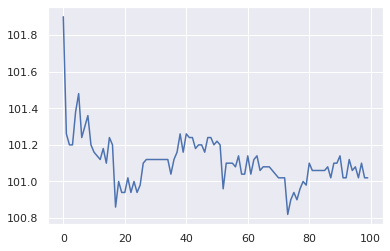

In [17]:
plt.plot(series)

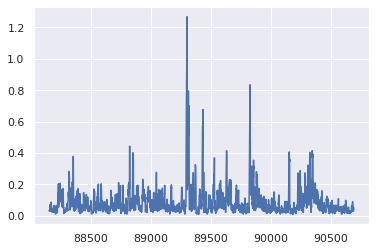

In [75]:
plt.plot(vals)

In [6]:
%%time
X_train = calc_all_tickers_feats(ticker2df, train_datetimes, np.timedelta64(1,'h'))

CPU times: user 1.44 s, sys: 988 ms, total: 2.43 s
Wall time: 2min 20s


In [38]:
%%time
y_train = calc_all_tickers_targets(ticker2df, train_datetimes, np.timedelta64(1,'h'))

CPU times: user 2.93 s, sys: 2.37 s, total: 5.3 s
Wall time: 2min 48s


In [43]:
X_val = calc_all_tickers_feats(ticker2df, val_datetimes, np.timedelta64(1,'h'))

In [44]:
y_val = calc_all_tickers_targets(ticker2df, val_datetimes, np.timedelta64(1,'h'))

In [39]:
X_train.shape

(2000, 38)

In [40]:
(y_train > 0.002).mean()

0.407

In [42]:
lgb = lgbm.sklearn.LGBMClassifier()
lgb.fit(X_train.drop(['corn_datetime', 'ticker'], axis=1), y_train > 0.002)


#pred_proba = lgb.predict_proba(X_val.drop(['corn_date', 'ticker'], axis=1)[best_feat_idxs])[:, 1]

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [46]:
pred_proba = lgb.predict_proba(X_val.drop(['corn_datetime', 'ticker'], axis=1))[:, 1]

In [52]:
log_loss(y_val > 0.002, pred_proba)

0.7532591937070333

In [57]:
log_loss(y_val[pred_proba > 0.9] > 0.002, pred_proba[pred_proba > 0.9])

0.5281704662761908

(array([ 45., 126., 215., 280., 290., 300., 288., 231., 152.,  73.]),
 array([0.0340979 , 0.12758671, 0.22107551, 0.31456432, 0.40805313,
        0.50154193, 0.59503074, 0.68851954, 0.78200835, 0.87549715,
        0.96898596]),
 <a list of 10 Patch objects>)

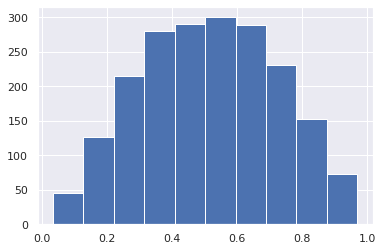

In [53]:
plt.hist(pred_proba)

In [43]:
y_val

array([0.0022457 , 0.00373134, 0.0030074 , ..., 0.00159067, 0.00479616,
       0.00370272])

In [37]:
pred_proba

array([0.74425161, 0.75724756, 0.27640063, ..., 0.71295781, 0.60290524,
       0.8223023 ])

In [46]:
X['y'] = y

(array([116.,  89.,  49.,  19.,  10.,   9.,   4.,   1.,   1.,   2.]),
 array([6.02280216e-05, 8.14788228e-04, 1.56934843e-03, 2.32390864e-03,
        3.07846885e-03, 3.83302905e-03, 4.58758926e-03, 5.34214946e-03,
        6.09670967e-03, 6.85126988e-03, 7.60583008e-03]),
 <a list of 10 Patch objects>)

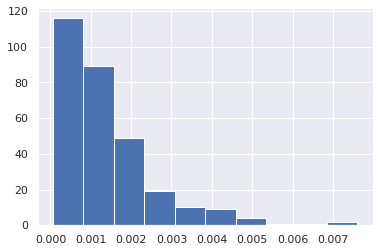

In [11]:
plt.hist(y)

In [ ]:
lgb.feature_importances_

In [ ]:
plt.plot(lgb.feature_importances_)

In [ ]:
plt.plot(lgb.feature_importances_)

In [ ]:
try:
    del X_val['profit']
    del X_val['profit_abs']
except:
    None

pred_proba = lgb.predict_proba(X_val.drop(['corn_date', 'ticker'], axis=1)[best_feat_idxs])[:, 1]
#pred_proba = lgb.predict(X_val.drop(['corn_date', 'ticker'], axis=1))

plt.plot(pred_proba)
plt.show()

# pred_proba_2 = lgb_2.predict_proba(X_val.drop(['corn_date', 'ticker'], axis=1))[:, 1]
# plt.plot(pred_proba_2)
# plt.show()

# pred_proba_3 = lgb_3.predict_proba(X_val.drop(['corn_date', 'ticker'], axis=1))[:, 1]
# plt.plot(pred_proba_3)

In [ ]:
plt.hist(pred_proba, bins=100)
plt.show()

In [ ]:
top_idxs = np.where(pred_proba > 0.7)[0]
len(top_idxs)

In [ ]:
y_val.mean(), y_val[top_idxs].mean()

In [ ]:
y_val.mean(), y_val[top_idxs].mean()

In [ ]:
from utils import *

y_val_profit = calc_target(val_target_dfs, single_profit_2, target_df_2_one_day_series)

In [ ]:
X_val['profit'] = y_val_profit
day_cnt_df = X_val.loc[top_idxs].groupby('corn_date').size().reset_index().rename({0:'cnt_per_day'}, axis=1)
X_val = pd.merge(X_val, day_cnt_df, on='corn_date', how='left')
X_val['volume'] = 2500000 / X_val['cnt_per_day']
X_val['profit_abs'] = X_val['volume'] * X_val['profit']
del X_val['cnt_per_day']
del X_val['volume']

In [ ]:
X_val.loc[top_idxs].groupby('corn_date')['profit_abs'].sum()

In [ ]:
X_val.loc[top_idxs]['profit_abs'].sum()

In [ ]:
54294.45376124319
45058.54288341864

In [ ]:
249540.7438308383
238265.8202385087
182758.77619388318
124229.31720323926
91517.8617101984
84287.5011097007

In [ ]:
X_day = X_val.loc[top_idxs]
X_day = X_day[X_day['corn_date'] == datetime.strptime("20190814", "%Y%m%d").date()]

In [ ]:
X_day

In [ ]:
profit

In [ ]:
idx = 237
#for idx in top_idxs:
corn_date = X_val.loc[idx]['corn_date']
ticker = X_val.loc[idx]['ticker']

df = ticker2df[ticker]
month_series = df_between(df, corn_date - timedelta(days=31), corn_date)['<OPEN>'].values
target_series = df_between(df, corn_date, corn_date + timedelta(days=1))['<OPEN>'].values


plt.figure(figsize=(25,10))
plt.title(ticker)
plt.plot(range(len(month_series)), month_series)
plt.plot(range(len(month_series), len(month_series) + len(target_series)), target_series)

buy_idx, sell_idx, profit = single_profit_2(target_series, return_idxs=True)

plt.scatter(len(month_series) + 1, target_series[0], color='k')
plt.scatter(len(month_series) + buy_idx, target_series[buy_idx], color='g')
plt.scatter(len(month_series) + sell_idx, target_series[sell_idx], color='r')

#plt.plot(range(len(month_series), len(month_series) + len(target_series)), y_val_series[84][-8], color='r')




plt.show()
corn_date

In [ ]:
int(datetime.now().strftime('%H'))

In [ ]:
lgb

In [ ]:
import pickle
with open('models/lgb_26_09_thr04.pickle', 'wb') as f:
    pickle.dump(lgb, f)

# Inference

In [ ]:
train_dates = [datetime.today().date() - timedelta(days=x) for x in range(1, 100)]

In [ ]:
X_train, y_train_series = all_samples(ticker2df, train_dates)


In [ ]:
y_train_profit = calc_target(y_train_series, single_profit_2) 

y_train = calc_target(y_train_series, single_target_3) > 0.01

lgb = lgbm.sklearn.LGBMClassifier()
lgb.fit(X_train.drop(['corn_date', 'ticker'], axis=1), y_train)

In [ ]:
test_start_day

In [ ]:
load_tickers(data_prefix="data/current", tickers=np.array(list(ibkr_info.keys())), start_date=datetime.today().date() - timedelta(days=40), end_date=datetime.today().date(), period=3)

In [ ]:
ticker2df_test = load_dfs('data/current', np.array(list(ibkr_info.keys())))

In [ ]:
X_test, y_test_series = all_samples(ticker2df_test, [datetime.today().date()], test_mode=True)

In [ ]:
import pickle
with open('models/lgb_26_09_thr04.pickle', 'rb') as f:
    lgb = pickle.load(f)

In [ ]:
X_test

In [ ]:
# del X_test['profit']
# del X_test['profit_abs']

In [ ]:
pred_proba = lgb.predict_proba(X_test.drop(['corn_date', 'ticker'], axis=1))[:, 1]
plt.plot(pred_proba)
plt.show()


In [ ]:
16990000 * 0.039235

In [ ]:
top_idxs = np.where(pred_proba > 0.25)[0]
top_idxs

In [ ]:
ticker2price = {}

for ticker in list(X_test.loc[top_idxs, ['ticker', 'corn_date']]['ticker'].values):
    
    df = ticker2df_test[ticker]
    price = df[df['date']==datetime.today().date()]['<OPEN>'].values[0]
    
    ticker2price[ticker] = price


ticker2price

In [ ]:
y_test_profit = calc_target(y_test_series, single_profit_2)

In [ ]:
X_test['profit'] = y_test_profit
day_cnt_df = X_test.loc[top_idxs].groupby('corn_date').size().reset_index().rename({0:'cnt_per_day'}, axis=1)
X_test = pd.merge(X_test, day_cnt_df, on='corn_date', how='left')
X_test['volume'] = 2000000 / X_test['cnt_per_day']
X_test['profit_abs'] = X_test['volume'] * X_test['profit']
del X_test['cnt_per_day']
del X_test['volume']

In [ ]:
top_idxs

In [ ]:
X_test.loc[top_idxs, ['ticker', 'corn_date']]

In [ ]:
X_test.loc[top_idxs, ['ticker', 'corn_date', 'profit', 'profit_abs']]

In [ ]:
X_test.loc[top_idxs, ['profit']].sum()

In [ ]:
X_test.loc[top_idxs, ['profit_abs']].sum()

In [ ]:
idx = 20
#for idx in top_idxs:
corn_date = X_test.loc[idx]['corn_date']
ticker = X_test.loc[idx]['ticker']

df = ticker2df_test[ticker]
month_series = df_between(df, corn_date - timedelta(days=31), corn_date)['<OPEN>'].values
target_series = df_between(df, corn_date, corn_date + timedelta(days=1))['<OPEN>'].values


plt.figure(figsize=(25,10))
plt.title(ticker)
plt.plot(range(len(month_series)), month_series)
plt.plot(range(len(month_series), len(month_series) + len(target_series)), target_series)

buy_idx, sell_idx = single_profit_2(np.array([0] + list(target_series)), return_idxs=True)
plt.scatter(len(month_series) + 1, target_series[0], color='k')
plt.scatter(len(month_series) + buy_idx - 1, target_series[buy_idx - 1], color='g')
plt.scatter(len(month_series) + sell_idx - 1, target_series[sell_idx - 1], color='r')

#plt.plot(range(len(month_series), len(month_series) + len(target_series)), y_val_series[84][-8], color='r')

# plt.axhline(y=11.573, linewidth=4, color='g')
# plt.axhline(y=11.675, linewidth=4, color='r')



plt.show()



In [ ]:
    series = np.array([0] + list(target_series))
    UPPER_COEF = 1.003
    BUY_HORIZON = 118
    can_buy = (series[2:BUY_HORIZON] <= series[1]*UPPER_COEF).max()

In [ ]:
can_buy

In [ ]:
series[2:BUY_HORIZON] <= series[1]*UPPER_COEF

In [ ]:
series

In [ ]:
datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

In [ ]:
data_prefix='data/train'
start_date=datetime.today().date() - timedelta(days=1)
end_date = datetime.today().date() + timedelta(days=1)

ticker='LKOH'
load_single(ticker, 'data/temp', start_date, end_date, 3)


df = pd.read_csv('data/train/{}.csv'.format(ticker))
df['date'] = df['<DATE>'].apply(lambda x: datetime.strptime(str(x), "%Y%m%d").date())

upd_df = pd.read_csv('data/temp/{}.csv'.format(ticker))
upd_df['date'] = upd_df['<DATE>'].apply(lambda x: datetime.strptime(str(x), "%Y%m%d").date())